#Becca
##---------------------------

In [1]:
import sys, os
cwd = os.getcwd()
sys.path[0] = cwd[:cwd.rfind('/')]

In [2]:
import numpy as np
import pandas as pd
from google.cloud import bigquery

In [3]:
#Google cloud credentials
os.environ['GOOGLE_APPLICATION_CREDENTIALS']='/content/Saltiest HN Trolls.json'

# Create a "Client" object
client = bigquery.Client()

# Bigquery dataset reference
hn_ref = client.dataset('hacker_news', project='hn-dataset')

In [4]:
# Run SQL query to obtain filtered table
query_string = """
SELECT C.by
FROM (
  SELECT A.by, COUNT(*) AS count
  FROM `bigquery-public-data.hacker_news.full` AS A
  GROUP BY A.by
  ORDER BY count DESC
  LIMIT 100
) AS C
WHERE C.by != "None"
"""

frequent_users = client.query(query_string).result().to_dataframe()

In [5]:
# This is a triple-nested query that gets a number of comments made only by the most
# frequent users.  Change the "LIMIT XXX" part of the inner-most query to tune the
# number of users.  Change the outermost "LIMIT YYY" to change the total number of comments.
query_string = """
SELECT *
FROM `bigquery-public-data.hacker_news.full` AS A
WHERE A.by IN (
  SELECT C.by
  FROM (
    SELECT A.by, COUNT(*) AS count
    FROM `bigquery-public-data.hacker_news.full` AS A
    GROUP BY A.by
    ORDER BY count DESC
    LIMIT 500
  ) AS C
  WHERE C.by != "None"
)
LIMIT 50000
"""

df = client.query(query_string).result().to_dataframe()

In [6]:
df.head()

,title,url,text,dead,by,score,time,timestamp,type,id,parent,descendants,ranking,deleted
0,None,None,Cannabis has never been &#x27;completely legal...,None,roel_v,NaN,1551582184,2019-03-03 03:03:04+00:00,comment,19292438,19292418.0,NaN,None,None
1,Starlight - History Channel,https://www.youtube.com/watch?v=U5F_ptPX7_8,None,None,bane,1.0,1379672467,2013-09-20 10:21:07+00:00,story,6416876,NaN,0.0,None,None
2,"Nepal bans solo, disabled and underaged climbe...",https://www.upi.com/Top_News/World-News/2017/1...,None,None,DoreenMichele,9.0,1514657287,2017-12-30 18:08:07+00:00,story,16036448,NaN,1.0,None,None
3,None,None,There are very few career mistakes that hurt y...,None,nostrademons,NaN,1306613116,2011-05-28 20:05:16+00:00,comment,2595097,2595030.0,NaN,None,None
4,None,None,"I dunno, man. What do you enjoy?<p>Pick a proj...",None,bitwize,NaN,1548884795,2019-01-30 21:46:35+00:00,comment,19039896,19039016.0,NaN,None,None


In [7]:
df.shape

(50000, 14)

In [8]:
df['by'].value_counts()

tptacek         767
dang            555
jacquesm        536
rbanffy         462
dragonwriter    440
               ... 
sillysaurus3     47
iProject         46
mehrdadn         45
crdoconnor       45
BurningFrog      39
Name: by, Length: 499, dtype: int64

In [9]:
df['type'].value_counts()

comment    44771
story       5198
pollopt       25
poll           6
Name: type, dtype: int64

In [10]:
# filter out by type (keep story and comment)
df[(df['type'] == 'story') | (df['type'] == 'comment')]

,title,url,text,dead,by,score,time,timestamp,type,id,parent,descendants,ranking,deleted
0,None,None,Cannabis has never been &#x27;completely legal...,None,roel_v,NaN,1551582184,2019-03-03 03:03:04+00:00,comment,19292438,19292418.0,NaN,None,None
1,Starlight - History Channel,https://www.youtube.com/watch?v=U5F_ptPX7_8,None,None,bane,1.0,1379672467,2013-09-20 10:21:07+00:00,story,6416876,NaN,0.0,None,None
2,"Nepal bans solo, disabled and underaged climbe...",https://www.upi.com/Top_News/World-News/2017/1...,None,None,DoreenMichele,9.0,1514657287,2017-12-30 18:08:07+00:00,story,16036448,NaN,1.0,None,None
3,None,None,There are very few career mistakes that hurt y...,None,nostrademons,NaN,1306613116,2011-05-28 20:05:16+00:00,comment,2595097,2595030.0,NaN,None,None
4,None,None,"I dunno, man. What do you enjoy?<p>Pick a proj...",None,bitwize,NaN,1548884795,2019-01-30 21:46:35+00:00,comment,19039896,19039016.0,NaN,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,None,None,In a recent job I ended up rewriting some of t...,None,grandalf,NaN,1434989168,2015-06-22 16:06:08+00:00,comment,9759256,9757892.0,NaN,None,None
49996,None,None,I would argue that the American right and Brit...,None,humanrebar,NaN,1360328326,2013-02-08 12:58:46+00:00,comment,5187597,5187474.0,NaN,None,None
49997,None,None,"Back in the late 1990s, my team's SourceSafe r...",None,cpeterso,NaN,1324150520,2011-12-17 19:35:20+00:00,comment,3364921,3364603.0,NaN,None,None
49998,None,None,We all see how well &quot;feeling safe is the ...,None,mschuster91,NaN,1444137331,2015-10-06 13:15:31+00:00,comment,10338606,10338572.0,NaN,None,None


In [11]:
# drop some columns
#drop title, has 447,218 null values 
#drop ranking, has 500000 null values
#drop score, has 446968 null values 
clean_df = df.drop(['time', 'descendants', 'deleted', 'url', 'dead', 'title', 'ranking', 'score'], axis=1)

In [12]:
# average of all texts
clean_df['text'].str.len().mean()

426.90236508325717

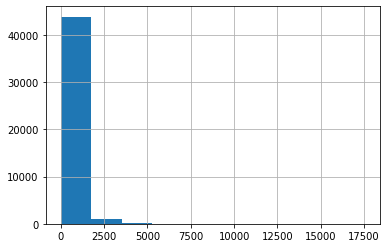

In [13]:
# histogram of all text lengths
clean_df['text'].str.len().hist()

In [14]:
# description of story texts
clean_df[clean_df['type'] == 'story']['text'].str.len().describe()

count      59.000000
mean      559.508475
std       648.102572
min        65.000000
25%       243.000000
50%       396.000000
75%       660.500000
max      4661.000000
Name: text, dtype: float64

In [15]:
# description of comment texts
clean_df[clean_df['type'] == 'comment']['text'].str.len().describe()

count    44771.000000
mean       426.969199
std        508.118165
min          1.000000
25%        144.000000
50%        278.000000
75%        522.000000
max      17564.000000
Name: text, dtype: float64

In [16]:
aux = clean_df[clean_df['type'] == 'comment']
aux2 = aux[aux['text'].str.len() <= 5]
aux2.head(10)

,text,by,timestamp,type,id,parent
2922,OK!,sctb,2018-08-16 21:54:26+00:00,comment,17778732,17778440.0
7546,Ok.,dang,2014-08-11 19:46:56+00:00,comment,8164864,8163726.0
7595,No.,SwellJoe,2008-09-01 06:11:58+00:00,comment,291752,291632.0
8690,yes.,signa11,2008-07-09 07:32:25+00:00,comment,240892,240787.0
10013,Yes.,Dylan16807,2015-11-17 16:00:10+00:00,comment,10581887,10580600.0
10887,Wow,tonyedgecombe,2015-07-23 12:21:34+00:00,comment,9935210,9935054.0
10997,.,jacobolus,2019-09-01 03:52:08+00:00,comment,20850404,20850397.0
11025,Yes.,toomuchtodo,2013-03-27 18:29:33+00:00,comment,5451141,5450475.0
11272,Aye.,jerf,2012-05-08 10:29:33+00:00,comment,3943008,3942913.0
12154,Done.,sctb,2017-02-13 18:45:40+00:00,comment,13637661,13637556.0


In [17]:
aux2.shape

(54, 6)

In [18]:
aux2['text'].nunique()

38

In [19]:
#only 507 comments with 5 characters or less, upon analysis doesn't look like they provide much context, 
#not helpful for model analysis so drop comments with 5 words or less

# take only the rows whose text column's length is greater than five
# this also removes the texts that are None
clean_df = clean_df[clean_df['text'].str.len() > 5]

In [20]:
clean_df.head()

,text,by,timestamp,type,id,parent
0,Cannabis has never been &#x27;completely legal...,roel_v,2019-03-03 03:03:04+00:00,comment,19292438,19292418.0
3,There are very few career mistakes that hurt y...,nostrademons,2011-05-28 20:05:16+00:00,comment,2595097,2595030.0
4,"I dunno, man. What do you enjoy?<p>Pick a proj...",bitwize,2019-01-30 21:46:35+00:00,comment,19039896,19039016.0
5,&gt;<i>That&#x27;s ignoring all the computing ...,coldtea,2016-04-27 17:19:53+00:00,comment,11582419,11578417.0
8,"Look, if you really want to debate this, I cou...",thaumaturgy,2012-09-04 00:15:50+00:00,comment,4472441,4472381.0


In [21]:
clean_df['text'].str.len().describe()

count    44804.000000
mean       427.440831
std        508.356942
min          6.000000
25%        145.000000
50%        278.000000
75%        522.000000
max      17564.000000
Name: text, dtype: float64

In [22]:
# Use BS on a single piece of text to remove strange chars and URLs and tags
from bs4 import BeautifulSoup

def clean_soup(text):
    # make a soup - this takes care of strange characters
    soup = BeautifulSoup(text, "html.parser")

    # delete <a> tags as they contain URLs -- remember <a href="url_here">
    # tags contain URLs
    for s in soup.select('a'):
       s.extract()

    # the soup contains <p> tags -- here we get rid of those and join them with spaces
    strings = soup.find_all(text=True, recursive=True)
    result = ' '.join(strings)

    return result

In [23]:
# Apply that to each comment/story text
clean_text = clean_df['text'].apply(clean_soup)

/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:336: UserWarning: "http:&#x2F;&#x2F;www.dailymail.co.uk&#x2F;news&#x2F;article-2579955&#x2F;US-officials-convinced-two-separate-communications-systems-Malaysian-jet-DELIBERATELY-shut-14-minutes-apart-emerges-aircraft-pinging-FIVE-hours-vanished-flying.html" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


In [24]:
clean_df['text'] = clean_text

In [25]:
import pandas as pd
pd.options.display.max_colwidth = 100
clean_df.sample(10)

,text,by,timestamp,type,id,parent
36800,"The CPU seems to have run at 4MHz ( ). However, I spot a 4.9152 MHz crystal on the photo of the ...",Someone,2017-12-27 12:32:29+00:00,comment,16014376,16011179.0
17383,In all the EF projects I have been on it caused weird issues after a while. Code first projects...,maxxxxx,2017-08-16 18:45:42+00:00,comment,15030033,15028785.0
9908,"The point you're making has nothing to do with the article. The article isn't ""meandering drivel...",tptacek,2012-09-26 19:16:51+00:00,comment,4577457,4577447.0
18654,"Thanks for the clarification - yep, I need to be able to create real symlinks on remote machines.",nailer,2009-04-18 16:37:16+00:00,comment,568468,568457.0
14576,> It's an abuse of the purpose of URL fragments Would you just look at who's preaching... If it...,huhtenberg,2019-02-15 16:37:29+00:00,comment,19172239,19169383.0
19169,"""Dual use"" in the ITAR sense? A rule of thumb would be if you wouldn't sell it to Iran you shoul...",pjc50,2019-02-23 00:02:38+00:00,comment,19230379,19230180.0
3996,">> Why is it so hard for a woman to bother a man with sexual harassment? Oh, that's actually ver...",YeGoblynQueenne,2018-08-09 00:02:25+00:00,comment,17720688,17717017.0
14905,> Presentation hasn't changed in 15 years. I think you mean 7. They changed their default theme ...,TazeTSchnitzel,2017-04-19 23:02:06+00:00,comment,14152556,14151406.0
25052,It's an abuse of HN to use it primarily for political or ideological battle. Since this account ...,dang,2017-08-10 07:34:26+00:00,comment,14977277,14976877.0
10447,Single page version,contingencies,2014-10-14 11:09:37+00:00,comment,8452835,8451905.0


In [26]:
#makes sense the parent would have some null values, if they are the first comment
clean_df.isnull().sum()

text          0
by            0
timestamp     0
type          0
id            0
parent       87
dtype: int64

#Pyrom
##---------------------------

In [27]:
pip install vaderSentiment

     |████████████████████████████████| 133kB 2.7MB/s 


In [28]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

#Panda Settings
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

In [29]:
clean_df.head()

,text,by,timestamp,type,id,parent
0,Cannabis has never been 'completely legal' anywhere in the Netherlands. It depends a bit though ...,roel_v,2019-03-03 03:03:04+00:00,comment,19292438,19292418.0
3,"There are very few career mistakes that hurt you permanently, if you make an effort to recover f...",nostrademons,2011-05-28 20:05:16+00:00,comment,2595097,2595030.0
4,"I dunno, man. What do you enjoy? Pick a project to work on in your free time. A game, an audio s...",bitwize,2019-01-30 21:46:35+00:00,comment,19039896,19039016.0
5,> That's ignoring all the computing work done before C. And we can really ignore it software wis...,coldtea,2016-04-27 17:19:53+00:00,comment,11582419,11578417.0
8,"Look, if you really want to debate this, I could try to defend what he said, but I will have to ...",thaumaturgy,2012-09-04 00:15:50+00:00,comment,4472441,4472381.0


In [30]:
df = clean_df.drop(columns=['timestamp', 'type', 'id', 'parent'])
df.head()

,text,by
0,Cannabis has never been 'completely legal' anywhere in the Netherlands. It depends a bit though ...,roel_v
3,"There are very few career mistakes that hurt you permanently, if you make an effort to recover f...",nostrademons
4,"I dunno, man. What do you enjoy? Pick a project to work on in your free time. A game, an audio s...",bitwize
5,> That's ignoring all the computing work done before C. And we can really ignore it software wis...,coldtea
8,"Look, if you really want to debate this, I could try to defend what he said, but I will have to ...",thaumaturgy


In [31]:
#Convert to string values
df = df.astype(str)

In [32]:
#No. of rows
df.shape

(44804, 2)

In [33]:
#Slim out users with less than 1000 comments, more manageable, cuts data in half
def slim(df):
    """
    Slim out dataset to user with 1000 or more comments.

    Returns a filtered dataframe.
    """

    X = df.copy()
    X = X.groupby('by').filter(lambda x: x['by'].count()<1000)

    return X

In [34]:
new_df = slim(df)
print(new_df.shape)
new_df.head()

(44804, 2)


,text,by
0,Cannabis has never been 'completely legal' anywhere in the Netherlands. It depends a bit though ...,roel_v
3,"There are very few career mistakes that hurt you permanently, if you make an effort to recover f...",nostrademons
4,"I dunno, man. What do you enjoy? Pick a project to work on in your free time. A game, an audio s...",bitwize
5,> That's ignoring all the computing work done before C. And we can really ignore it software wis...,coldtea
8,"Look, if you really want to debate this, I could try to defend what he said, but I will have to ...",thaumaturgy


In [35]:
#No. of usernames
new_df['by'].value_counts().sum()

44804

In [36]:
new_df.isnull().sum()

text    0
by      0
dtype: int64

In [37]:
#Machine Learning, using VADER Sentiment Analysis

def sentiment_score(comment):
    analyser = SentimentIntensityAnalyzer()
    
    x = 0
    score = analyser.polarity_scores(comment)
    x = x + score['pos']
    x = x + score['compound']
    x = x - score['neg'] 

    return x

In [38]:
#Apply function to 'text' column, values added to new column called Saltiness
new_df['Saltiness'] = new_df['text'].apply(sentiment_score)

In [39]:
new_df.head()

,text,by,Saltiness
0,Cannabis has never been 'completely legal' anywhere in the Netherlands. It depends a bit though ...,roel_v,0.0612
3,"There are very few career mistakes that hurt you permanently, if you make an effort to recover f...",nostrademons,0.2880
4,"I dunno, man. What do you enjoy? Pick a project to work on in your free time. A game, an audio s...",bitwize,1.0888
5,> That's ignoring all the computing work done before C. And we can really ignore it software wis...,coldtea,-0.4174
8,"Look, if you really want to debate this, I could try to defend what he said, but I will have to ...",thaumaturgy,-1.0465


In [40]:
#Rename columns
new_df.columns = ['Comment', 'Username', 'Saltiness']

In [41]:
#Rearrange columns, sort by username
order = ['Username', 'Comment', 'Saltiness']
users_score = new_df[order]

In [42]:
#Sort
users_score.sort_values(by=['Username'], inplace=True)

In [43]:
#def add_rank(df):
    
    # Create separate dataframe based on user overall rank
    # Reset index twice to get new numeric column
#    rank_df = df.groupby('Username')['Saltiness'].sum().sort_values(ascending=True).reset_index().reset_index()
    
    # Add 1 to get the rank
#    rank_df['index'] = rank_df['index'] + 1
    
    # Wrangle the rank_df
#    rank_df = rank_df[['index', 'Username']]
    
    # Change the rank_df column names
#    rank_df.columns = ['Ranking', 'Username']
    
    # Left merge rank_df with original df on 'author' column
#    merged = pd.merge(df, rank_df, how='left', on='Username')
    
    # Wrangle merged dataframe
    #merged = merged.drop(columns=['ranking_x', 'deleted', 'dead'])
    
    # Rename columns
    #merged.columns = ['Username','Saltiness', 'Ranking']
    
#    return merged

In [44]:
#letssee = add_rank(new_df)
#letssee.head()

In [45]:
#Drop comment column, and groupby username
users_score.drop(columns=['Comment'], inplace=True)
users_score.head()

,Username,Saltiness
36228,001sky,0.0000
40512,001sky,-0.5956
2880,001sky,0.0000
427,001sky,0.2942
30998,001sky,0.8908


In [47]:
users_score.head()

,Username,Saltiness
36228,001sky,0.0000
40512,001sky,-0.5956
2880,001sky,0.0000
427,001sky,0.2942
30998,001sky,0.8908


In [ ]:
users_score.groupby('Username', as_index=False)['Saltiness'].mean()

In [56]:
#users_score = users_score.set_index('Username')

In [67]:
#users_score = users_score.groupby('Username').sum()

In [58]:
users_score.head()

,Saltiness
Username,
001sky,-0.6138
Alex3917,15.0743
AndrewKemendo,12.1152
AnimalMuppet,10.3761
Animats,6.5789


In [61]:
users_score = users_score.reset_index()

In [64]:
#Convert Saltiness column to percent
#users_score['Saltiness']=users_score['Saltiness'].apply('{:.0%}'.format) 
#users_score.head()

,Username,Saltiness
0,001sky,-61%
1,Alex3917,1507%
2,AndrewKemendo,1212%
3,AnimalMuppet,1038%
4,Animats,658%


In [68]:
users_score.head(30)

,Saltiness
Username,
001sky,-61%
Alex3917,1507%
AndrewKemendo,1212%
AnimalMuppet,1038%
Animats,658%
Anon84,689%
AnthonyMouse,1708%
Apocryphon,551%
AstralStorm,117%
